<a href="https://colab.research.google.com/github/melsanajisaputra/UTS_Analisa-pengolahan-citra-digital/blob/main/UTS_P%26_A_C_D_MELSAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#-------------------------------------------------------------------------------
# **UTS Pengolahan & Analisa Citra Digital by. Melsan Aji Saputra (220201063)**
#-------------------------------------------------------------------------------

# **SOAL**
Dalam tugas ini, Anda diminta untuk memperluas proyek yang ada di bawah dengan menambahkan satu algoritma baru. Algoritma yang ditambahkan harus relevan dengan konteks proyek dan memberikan nilai tambah dalam hal efisiensi, kecepatan, atau kegunaan.

# **JAWABAN**
Berdasarkan Pengolahan image_classification_using_CNN pada contoh Project UTS https://github.com/agustinus58/Klasifikasi-Daun-Herbal , Maka saya akan memperluas proyek dengan menambahkan 1 Algoritma baru yang dapat memberikan nilai tambah dalam hal efisiensi, kecepatan, atau kegunaan. Yang menjadi dasar saya untuk menentukan Algoritma baru yaitu saya menemukan Research Gap pada model CNN yang sudah di terapkan.

Research Gapnya adalah :
1. Resolusi gambar terlalu kecil (32×32)
2. Dataset kecil dan belum di-augmentasi
3. Model CNN masih sederhana
4. Tidak ada callback untuk kontrol training
5. Tidak ada visualisasi confusion matrix
6. Tidak dilakukan normalisasi channel mean / standardization
7. Tidak ada analisis kinerja model (akurasi, loss curve, waktu training, dll)
8. Tidak ada penjelasan atau visualisasi interpretasi model

Oleh karena itu, saya akan melakukan percobaan perbandingan Algortima CNN (Algoritma awal) VS MobileNetV2 vs ResNet50 serta saya akan melengkapi kekurangannya.
Disini saya menggunakan dataset yang sama tetapi saya seimbangkan sehingga dapat dilakukan pengolahan dengan beberapa algoritma.

#**#CNN VS MobileNetV2 vs ResNet50**

In [ ]:
# 1. IMPORT LIBRARY
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drives/')

Mounted at /content/drives/


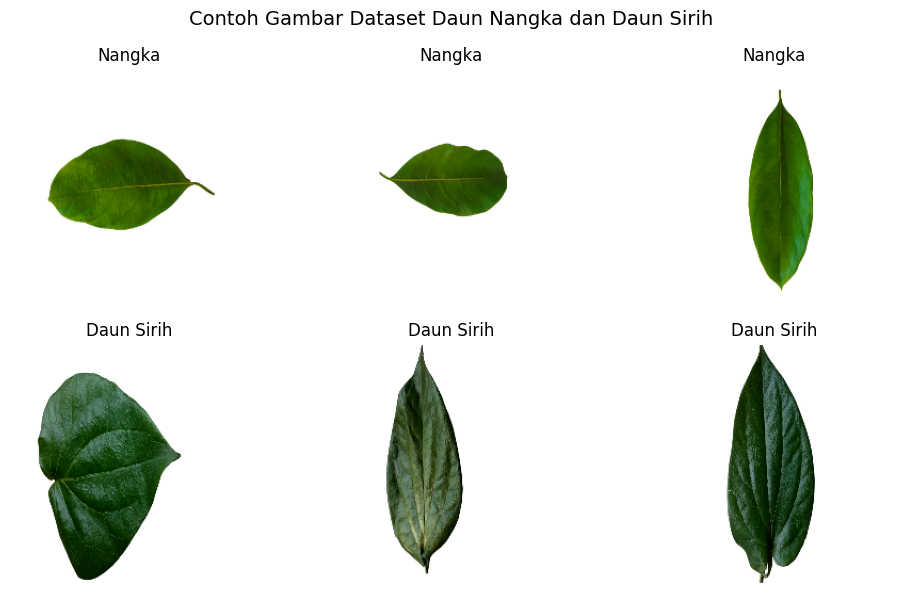

In [ ]:
# 3. Memanggil Dataset
imagePaths = '/content/drives/MyDrive/UTS/DatasetDaun'
label_list = ['Nangka', 'Daun Sirih']

data, labels = [], []

IMG_SIZE = 224  # Ukuran gambar agar cocok dengan model
for label in label_list:
    image_dir = imagePaths + '/' + label + '/*.jpg'
    for imagePath in glob.glob(image_dir):
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        data.append(image)
        labels.append(label)

data = np.array(data, dtype='float')
labels = np.array(labels)
plt.figure(figsize=(10, 6))
num_samples = 3  # jumlah gambar per kelas yang ingin ditampilkan
idx_nangka = np.where(labels == 'Nangka')[0][:num_samples]
idx_sirih = np.where(labels == 'Daun Sirih')[0][:num_samples]

for i, idx in enumerate(idx_nangka):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(cv2.cvtColor(data[idx].astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("Nangka")
    plt.axis('off')

for i, idx in enumerate(idx_sirih):
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(cv2.cvtColor(data[idx].astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("Daun Sirih")
    plt.axis('off')

plt.suptitle("Contoh Gambar Dataset Daun Nangka dan Daun Sirih", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# 4. Pelabelan Dataset & Normalisasi
lb = LabelEncoder()
labels = lb.fit_transform(labels)
data = data / 255.0
print("\nLabel unik:", lb.classes_)
print("Contoh label hasil encoding:", labels[:10])



Label unik: ['Daun Sirih' 'Nangka']
Contoh label hasil encoding: [1 1 1 1 1 1 1 1 1 1]


In [ ]:
# 5. Split Dataset
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels)
print("\nUkuran data:")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Ukuran data:
x_train: (81, 224, 224, 3)
x_test: (21, 224, 224, 3)
y_train: (81,)
y_test: (21,)


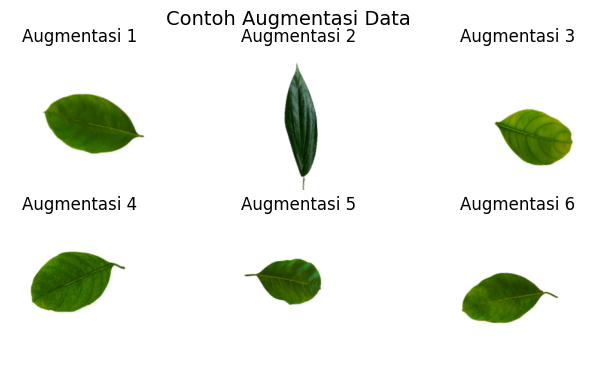

In [ ]:
# 6. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# tampilkan contoh augmentasi
plt.figure(figsize=(8,4))
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=6):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(cv2.cvtColor((x_batch[i]*255).astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.title(f"Augmentasi {i+1}")
        plt.axis('off')
    break
plt.suptitle("Contoh Augmentasi Data", fontsize=14)
plt.show()

In [ ]:
# 7. Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [ ]:
# 8. DEFINISI MODEL CNN
model_cnn = Sequential([
    InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPool2D(2,2),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,400,129 (196.08 MB)

 Trainable params: 51,400,129 (196.08 MB)

 Non-trainable params: 0 (0.00 B)

Melatih Model CNN Manual ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.4786 - loss: 1.1782 - val_accuracy: 0.4762 - val_loss: 1.2144 - learning_rate: 1.0000e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6056 - loss: 0.9146 - val_accuracy: 0.5238 - val_loss: 0.8960 - learning_rate: 1.0000e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5845 - loss: 0.8060 - val_accuracy: 0.4762 - val_loss: 0.9193 - learning_rate: 1.0000e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.5851 - loss: 0.9615 - val_accuracy: 0.9524 - val_loss: 0.4892 - learning_rate: 1.0000e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6658 - loss: 0.6364 - val_accuracy: 0.5238 - val_loss: 0.6800 - learning_rate: 1.0000e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5496 - loss: 0.8947 - val_accuracy: 0.7619 - val_loss: 0.4650 - learning_rate: 1.0000e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5993 - loss: 0.6491 - val_

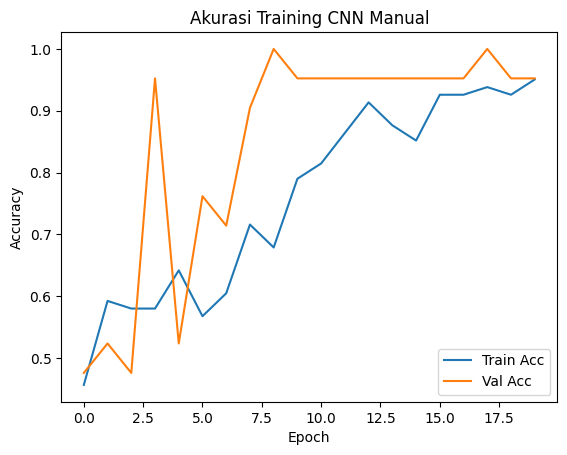

In [ ]:
# 9. TRAINING CNN MANUAL
print("Melatih Model CNN Manual ...")
start = time.time()
H_cnn = model_cnn.fit(datagen.flow(x_train, y_train, batch_size=32),
                      validation_data=(x_test, y_test),
                      epochs=20, callbacks=callbacks, verbose=1)
time_cnn = time.time() - start

# menampilkan grafik hasil training
plt.plot(H_cnn.history['accuracy'], label='Train Acc')
plt.plot(H_cnn.history['val_accuracy'], label='Val Acc')
plt.title("Akurasi Training CNN Manual")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Melatih Model MobileNetV2 ...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5800 - loss: 0.8487 - val_accuracy: 0.7143 - val_loss: 0.5738 - learning_rate: 1.0000e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5585 - loss: 0.8137 - val_accuracy: 0.8095 - val_loss: 0.4925 - learning_rate: 1.0000e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5736 - loss: 0.7468 - val_accuracy: 0.9048 - val_loss: 0.4218 - learning_rate: 1.0000e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6312 - loss: 0.6896 - val_accuracy: 1.0000 - val_loss: 0.3636 - learning_rate: 1.0000e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6795 - loss: 0.6189 - val_accuracy: 1.0000 - val_loss: 0.3185 - learning_rate: 1.0000e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7398 - loss: 0.5198 - val_accuracy: 1.0000 - val_loss: 0.2817 - learning_rate: 1.0000e-04
Epoch 7/20
3/3

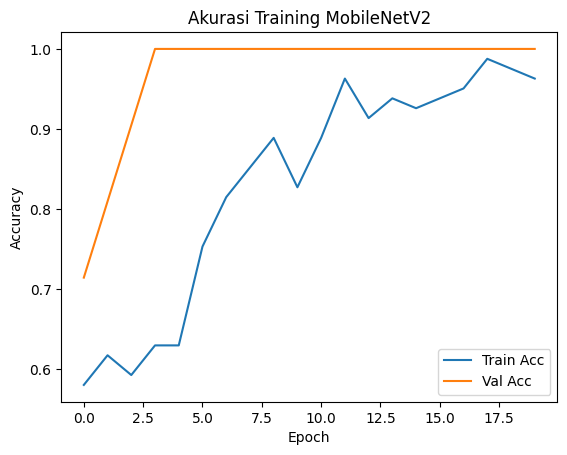

In [ ]:
# 10. MODEL TRANSFER LEARNING : MobileNetV2
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_mobilenet.trainable = False
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)
model_mobilenet = Model(inputs=base_mobilenet.input, outputs=preds)
model_mobilenet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print("Melatih Model MobileNetV2 ...")
start = time.time()
H_mobilenet = model_mobilenet.fit(datagen.flow(x_train, y_train, batch_size=32),
                                  validation_data=(x_test, y_test),
                                  epochs=20, callbacks=callbacks, verbose=1)
time_mobilenet = time.time() - start

plt.plot(H_mobilenet.history['accuracy'], label='Train Acc')
plt.plot(H_mobilenet.history['val_accuracy'], label='Val Acc')
plt.title("Akurasi Training MobileNetV2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Melatih Model ResNet50 ...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - accuracy: 0.5245 - loss: 0.8585 - val_accuracy: 0.4762 - val_loss: 0.7004 - learning_rate: 1.0000e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.5883 - loss: 0.7171 - val_accuracy: 0.6190 - val_loss: 0.6741 - learning_rate: 1.0000e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.5766 - loss: 0.7727 - val_accuracy: 0.5238 - val_loss: 0.6619 - learning_rate: 1.0000e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.5209 - loss: 0.7430 - val_accuracy: 0.5238 - val_loss: 0.6568 - learning_rate: 1.0000e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.5434 - loss: 0.7298 - val_accuracy: 0.5238 - val_loss: 0.6507 - learning_rate: 1.0000e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.4414 - loss: 0.8905 - val_accuracy: 0.5238 - val_loss: 0.6429 - learning_rate: 1.0000e-04
Epoch 7/20

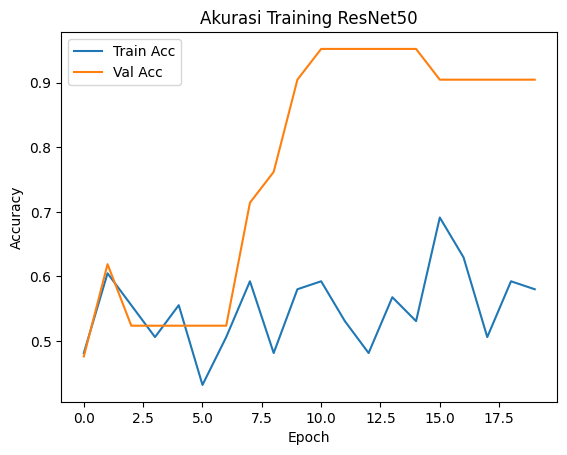

In [ ]:
# 11. MODEL TRANSFER LEARNING : ResNet50
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_resnet.trainable = False
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)
model_resnet = Model(inputs=base_resnet.input, outputs=preds)
model_resnet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print("Melatih Model ResNet50 ...")
start = time.time()
H_resnet = model_resnet.fit(datagen.flow(x_train, y_train, batch_size=32),
                            validation_data=(x_test, y_test),
                            epochs=20, callbacks=callbacks, verbose=1)
time_resnet = time.time() - start

plt.plot(H_resnet.history['accuracy'], label='Train Acc')
plt.plot(H_resnet.history['val_accuracy'], label='Val Acc')
plt.title("Akurasi Training ResNet50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Evaluasi CNN Manual 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
Akurasi CNN Manual: 0.9524
Waktu training: 255.53 detik
              precision    recall  f1-score   support

      Nangka       1.00      0.91      0.95        11
  Daun Sirih       0.91      1.00      0.95        10

    accuracy                           0.95        21
   macro avg       0.95      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21



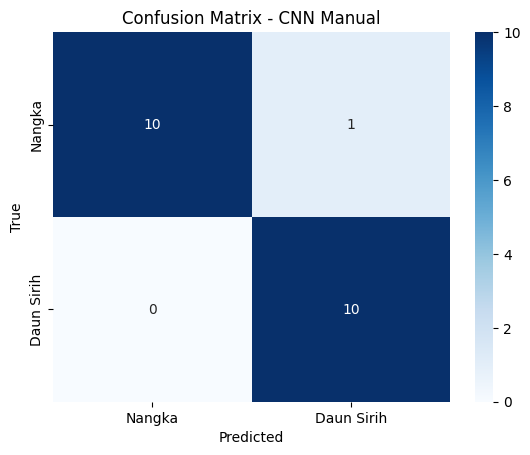

Evaluasi MobileNetV2 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Akurasi MobileNetV2: 1.0000
Waktu training: 121.35 detik
              precision    recall  f1-score   support

      Nangka       1.00      1.00      1.00        11
  Daun Sirih       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



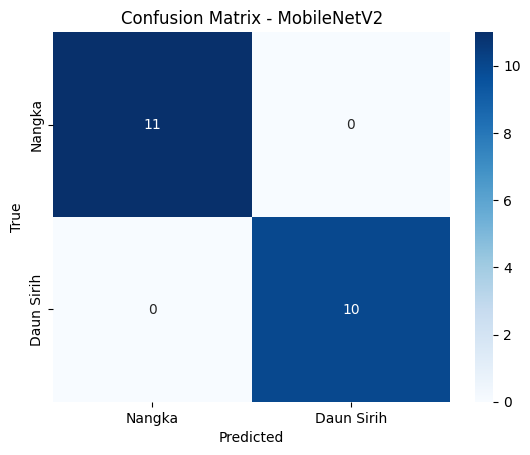

Evaluasi ResNet50 
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Akurasi ResNet50: 0.9048
Waktu training: 493.09 detik
              precision    recall  f1-score   support

      Nangka       0.85      1.00      0.92        11
  Daun Sirih       1.00      0.80      0.89        10

    accuracy                           0.90        21
   macro avg       0.92      0.90      0.90        21
weighted avg       0.92      0.90      0.90        21



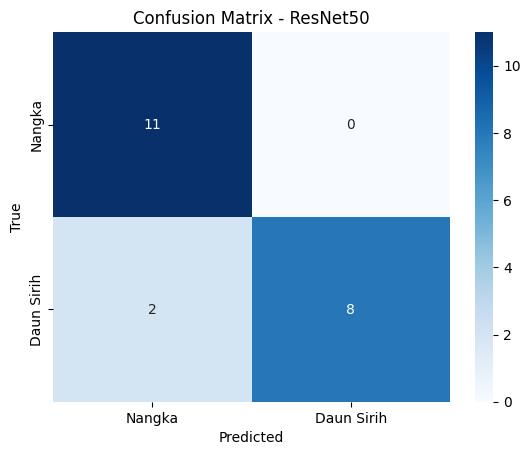

In [ ]:
# 12. EVALUASI DAN PERBANDINGAN
models = {
    "CNN Manual": (model_cnn, H_cnn, time_cnn),
    "MobileNetV2": (model_mobilenet, H_mobilenet, time_mobilenet),
    "ResNet50": (model_resnet, H_resnet, time_resnet)
}

results = {}

for name, (model, H, t) in models.items():
    print(f"Evaluasi {name} ")
    y_pred = (model.predict(x_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    print(f"Akurasi {name}: {acc:.4f}")
    print(f"Waktu training: {t:.2f} detik")
    print(classification_report(y_test, y_pred, target_names=label_list))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_list, yticklabels=label_list)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    results[name] = {
        "Accuracy": acc,
        "Training Time (s)": round(t,2)
    }

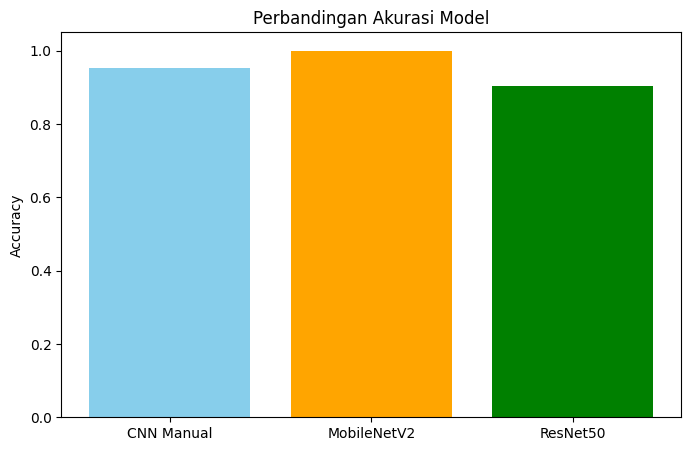

In [ ]:
# 13. GRAFIK PERBANDINGAN AKURASI ANTAR MODEL
plt.figure(figsize=(8,5))
plt.bar(results.keys(), [v["Accuracy"] for v in results.values()],
        color=['skyblue','orange','green'])
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# 14. TABEL RINGKASAN HASIL
df = pd.DataFrame(results).T
print("\nTabel Ringkasan Hasil:")
display(df)


Tabel Ringkasan Hasil:


,Accuracy,Training Time (s)
CNN Manual,0.952381,255.53
MobileNetV2,1.000000,121.35
ResNet50,0.904762,493.09


Berdasarkan hasil pengujian dan perbandingan antara tiga model (CNN Manual, MobileNetV2, dan ResNet50) pada dataset daun nangka dan daun sirih yang sama, Maka diperoleh bahwa MobileNetV2 memberikan performa terbaik dengan kombinasi akurasi tinggi, waktu komputasi cepat, dan stabilitas hasil yang baik.
Oleh karena itu, model MobileNetV2 saya pilih sebagai model utama dalam pengembangan sistem klasifikasi citra pada project UTS ini.
Dibawah ini, saya lakukan kembali pengelolaan daun menggunakan MODEL TRANSFER LEARNING: MobileNetV2

In [1]:
# 1. IMPORT LIBRARY
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
# 2. MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drives/')

Mounted at /content/drives/


In [3]:
# 3. LOAD DATASET
imagePaths = '/content/drives/MyDrive/UTS/DatasetDaun'
label_list = ['Nangka', 'Daun Sirih']
data = []
labels = []

print("Memuat dataset...")
for label in label_list:
    image_dir = os.path.join(imagePaths, label, '*.jpg')
    print(f"Mengambil gambar dari: {image_dir}")
    for imagePath in glob.glob(image_dir):
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (224, 224))   # MobileNetV2 menggunakan input 224x224
        data.append(image)
        labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("Total data:", len(data))

Memuat dataset...
Mengambil gambar dari: /content/drives/MyDrive/UTS/DatasetDaun/Nangka/*.jpg
Mengambil gambar dari: /content/drives/MyDrive/UTS/DatasetDaun/Daun Sirih/*.jpg
Total data: 102


In [4]:
# 4. ENCODE LABEL & SPLIT DATA
lb = LabelEncoder()
labels_encoded = lb.fit_transform(labels)
print("Label Asli:", label_list)
print("Label Encode:", np.unique(labels_encoded))

x_train, x_test, y_train, y_test = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

print("Ukuran Data Train:", x_train.shape)
print("Ukuran Data Test:", x_test.shape)

Label Asli: ['Nangka', 'Daun Sirih']
Label Encode: [0 1]
Ukuran Data Train: (81, 224, 224, 3)
Ukuran Data Test: (21, 224, 224, 3)


In [5]:
# 5. DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(x_train)

In [6]:
# 6. BANGUN MODEL TRANSFER LEARNING: MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_shape=(224, 224, 3))

# Freeze layer base
for layer in baseModel.layers:
    layer.trainable = False

# Tambahkan classifier baru
model = Sequential([
    baseModel,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# 7. KOMPILE MODEL
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

print("\n Struktur Model:")
model.summary()


 Struktur Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# 8. TRAINING MODEL
print("Mulai training MobileNetV2...")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=20,
    verbose=1
)


Mulai training MobileNetV2...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9938 - loss: 0.1236 - val_accuracy: 1.0000 - val_loss: 0.0917
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9659 - loss: 0.1328 - val_accuracy: 1.0000 - val_loss: 0.0879
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9366 - loss: 0.1405 - val_accuracy: 1.0000 - val_loss: 0.0842
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9887 - loss: 0.1250 - val_accuracy: 1.0000 - val_loss: 0.0807
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9659 - loss: 0.1116 - val_accuracy: 1.0000 - val_loss: 0.0760
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9686 - loss: 0.1243 - val_accuracy: 1.0000 - val_loss: 0.0720
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9887 - loss: 0.1034 - val_accuracy: 1.0000 - val_loss: 0.0689
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9938 - loss: 0.0826 - val_accuracy: 1.0000 - val

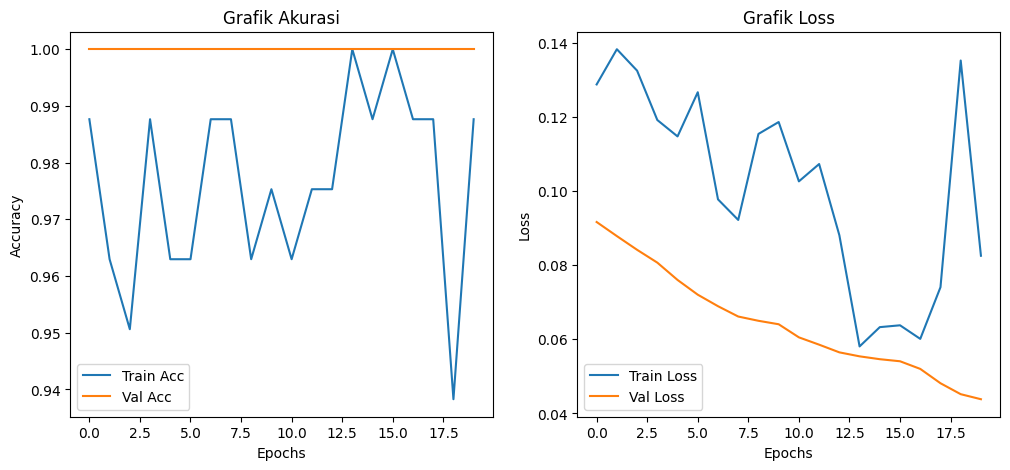

In [11]:
# 9. GRAFIK AKURASI DAN LOSS
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Grafik Akurasi")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Grafik Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [12]:
# 10. EVALUASI MODEL
print("Evaluasi Model:")
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f" Akurasi Data Test: {acc*100:.2f}%")
print(f" Loss Data Test: {loss:.4f}")


Evaluasi Model:
 Akurasi Data Test: 100.00%
 Loss Data Test: 0.0438


In [13]:
# 11. LAPORAN KLASIFIKASI
predictions = (model.predict(x_test) > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test, predictions, target_names=label_list))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

      Nangka       1.00      1.00      1.00        11
  Daun Sirih       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



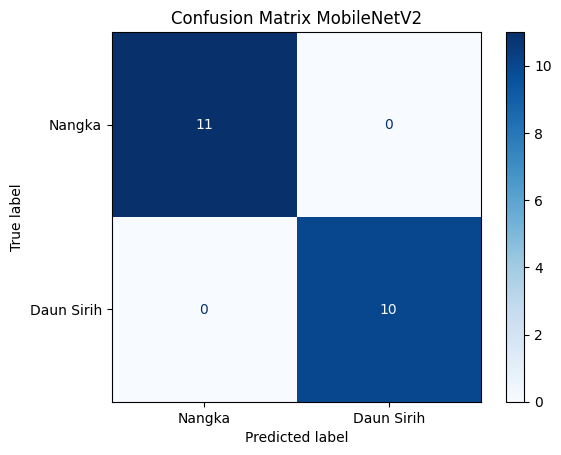

In [14]:
# 12. CONFUSION MATRIX
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix MobileNetV2")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Gambar Nangka: Prediksi = Nangka
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Gambar Daun Sirih: Prediksi = Daun Sirih


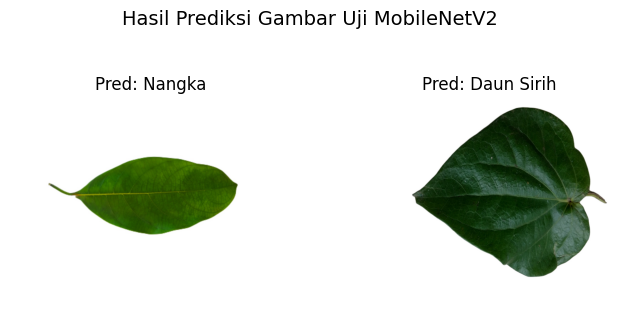

In [15]:
# 13. PENGUJIAN DENGAN GAMBAR NANGKA DAN DAUN SIRIH
import matplotlib.pyplot as plt
import cv2
import numpy as np

# List gambar uji
test_images = [
    ('Nangka', imagePaths + '/Nangka/023.jpg'),
    ('Daun Sirih', imagePaths + '/Daun Sirih/023.jpg')
]

plt.figure(figsize=(8,4))

for i, (label_true, path) in enumerate(test_images):
    img = cv2.imread(path)
    if img is None:
        print(f"Gambar {path} tidak ditemukan!")
        continue

    # Salin gambar untuk ditampilkan
    img_display = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    # Preprocessing untuk prediksi
    img_resized = cv2.resize(img, (224, 224))
    img_preprocessed = np.expand_dims(img_resized, axis=0) / 255.0

    # Prediksi
    pred = model.predict(img_preprocessed)
    pred_label = "Nangka" if pred > 0.5 else "Daun Sirih"

    # Print hasil prediksi di console
    print(f"Gambar {label_true}: Prediksi = {pred_label}")

    # Tampilkan gambar dengan label prediksi
    plt.subplot(1, 2, i+1)
    plt.imshow(img_display)
    plt.title(f"\nPred: {pred_label}")
    plt.axis("off")

plt.suptitle("Hasil Prediksi Gambar Uji MobileNetV2", fontsize=14)
plt.show()

In [16]:
# 15. SIMPAN MODEL

model.save('/content/drives/MyDrive/Data/mobilenetv2_daun.h5')
print("Model telah Berhasil disimpan di Google Drive.")

Model telah Berhasil disimpan di Google Drive.


# **Sekian dan Terimakasih**
# ------------------------------------------------------------------------------
# **Auth. Melsan Aji Saputra**
